### 타이타닉 데이터 이진분류 정확도 검사

- 패키지 / 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
titanic = sns.load_dataset('titanic')
titanic.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


- 데이터 전처리

In [4]:
titanic = titanic[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]
titanic.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S


In [5]:
# 결측치 확인
titanic.isna().sum()

survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64

In [6]:
# age 컬럼은 평균으로 대체
titanic.age.fillna(titanic.age.mean(), inplace=True)
titanic.age.isna().sum()

0

In [7]:
# embarked 컬럼은 최빈값으로 대체
titanic.embarked.value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [8]:
titanic.embarked.fillna("S", inplace =True)
titanic.isna().sum()

survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

In [9]:
# LabelEncoder로 변환 (sex, embarked 항목)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [10]:
titanic.sex = le.fit_transform(titanic.sex)
titanic.embarked = le.fit_transform(titanic.embarked)
titanic.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2


In [11]:
# X와 y를 넘파이 배열로
X = titanic.iloc[:,1:].values
y = titanic.iloc[:,0].values # survived 값
X.shape, y.shape

((891, 7), (891,))

In [33]:
# X 스케일링
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)
X_scaled.shape

(891, 7)

- 학습 / 테스트 데이터셋 분리

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=2022
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 7), (179, 7), (712,), (179,))

- 모델 정의

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [35]:
model = Sequential([
    Dense(32, input_shape=(7,), activation='relu'),
    Dense(16, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                256       
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 4)                 68        
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 857
Trainable params: 857
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

- 모델 저장 조건 등 설정

In [37]:
import os # 파일 생성하기
if not os.path.exists('model'):
    os.mkdir('model')

In [38]:
model_path = 'model/titanic.h5'

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(
    model_path, monitor= 'val_loss', verbose = 1, save_best_only = True)
early_stop = EarlyStopping(patience=20)

- 모델 학습

In [40]:
hist = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=200,
                verbose =0, callbacks=[checkpoint, early_stop])


Epoch 00001: val_loss improved from inf to 0.73057, saving model to model/titanic.h5

Epoch 00002: val_loss improved from 0.73057 to 0.71591, saving model to model/titanic.h5

Epoch 00003: val_loss improved from 0.71591 to 0.70267, saving model to model/titanic.h5

Epoch 00004: val_loss improved from 0.70267 to 0.69192, saving model to model/titanic.h5

Epoch 00005: val_loss improved from 0.69192 to 0.68460, saving model to model/titanic.h5

Epoch 00006: val_loss improved from 0.68460 to 0.67988, saving model to model/titanic.h5

Epoch 00007: val_loss improved from 0.67988 to 0.67638, saving model to model/titanic.h5

Epoch 00008: val_loss improved from 0.67638 to 0.67332, saving model to model/titanic.h5

Epoch 00009: val_loss improved from 0.67332 to 0.67011, saving model to model/titanic.h5

Epoch 00010: val_loss improved from 0.67011 to 0.66700, saving model to model/titanic.h5

Epoch 00011: val_loss improved from 0.66700 to 0.66399, saving model to model/titanic.h5

Epoch 00012: 

- 모델 평가

In [41]:
from tensorflow.keras.models import load_model
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.5186 - accuracy: 0.8268


[0.5186324119567871, 0.826815664768219]

- 조건 변경해서 한번 더

In [44]:
del model

In [45]:
model = Sequential([
    Dense(400, input_shape=(7,), activation='relu'),
    Dense(200, activation='relu'),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 400)               3200      
                                                                 
 dense_15 (Dense)            (None, 200)               80200     
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 50)                5050      
                                                                 
 dense_18 (Dense)            (None, 25)                1275      
                                                                 
 dense_19 (Dense)            (None, 1)                 26        
                                                                 
Total params: 109,851
Trainable params: 109,851
Non-tr

In [47]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [48]:
hist = model.fit(X_train, y_train, validation_split=0.2, epochs=300, batch_size=200,
                verbose =0, callbacks=[checkpoint, early_stop])


Epoch 00001: val_loss did not improve from 0.55726

Epoch 00002: val_loss did not improve from 0.55726

Epoch 00003: val_loss improved from 0.55726 to 0.52332, saving model to model/titanic.h5

Epoch 00004: val_loss improved from 0.52332 to 0.49265, saving model to model/titanic.h5

Epoch 00005: val_loss did not improve from 0.49265

Epoch 00006: val_loss did not improve from 0.49265

Epoch 00007: val_loss did not improve from 0.49265

Epoch 00008: val_loss improved from 0.49265 to 0.47871, saving model to model/titanic.h5

Epoch 00009: val_loss improved from 0.47871 to 0.46814, saving model to model/titanic.h5

Epoch 00010: val_loss improved from 0.46814 to 0.46341, saving model to model/titanic.h5

Epoch 00011: val_loss improved from 0.46341 to 0.46023, saving model to model/titanic.h5

Epoch 00012: val_loss did not improve from 0.46023

Epoch 00013: val_loss did not improve from 0.46023

Epoch 00014: val_loss did not improve from 0.46023

Epoch 00015: val_loss did not improve from 

In [49]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.4053 - accuracy: 0.8380


[0.4052715599536896, 0.8379888534545898]

- 학습과정 시각화

In [51]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

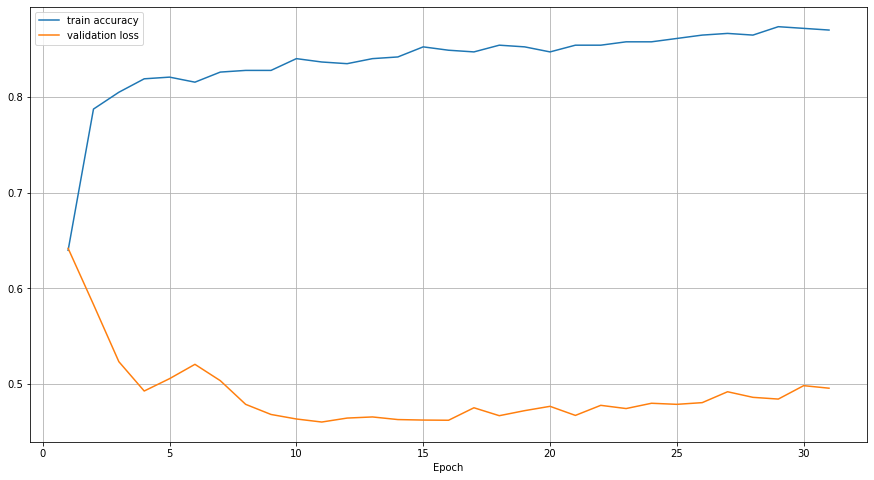

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.grid()
plt.show()